# Part 1 - Importing necessary packages

If installation was done correctly, there should be no errors here.

In [1]:
%matplotlib inline

# Numerical library
import numpy as np

# Data manipulation
import pandas as pd
from patsy import dmatrix

# Ploting
import matplotlib
import matplotlib.pyplot as plt

# Survival analysis
import lifelines

# Part 2 - A look at the clinical data
The data is originally avaliable at http://www.cbioportal.org/study?id=brca_tcga_pub, but it can also be found together with this notebook at https://github.com/gjeuken/survival-workshop.

We will use here clinical data on the patients as well as gene expression data. Firstly, lets load the clinical data and see what it looks like. Make a note of all the variables (columns) avaliable in the data.

In [2]:
clinical = pd.read_csv('data/brca_tcga_pub_clinical_data.tsv', sep='\t')

with pd.option_context('display.max_columns', None):
    display(clinical)

,Patient ID,Sample ID,CN Cluster,Cancer Studies,Cancer Type,Cancer Type Detailed,Converted Stage,Diagnosis Age,ER Status,HER2 Status,Integrated Clusters (no exp),Integrated Clusters (unsup exp),Integrated Clusters (with PAM50),MIRNA Cluster,Metastasis,Metastasis-Coded,Methylation Cluster,Node,Node-Coded,Oncotree Code,Overall Survival (Months),Overall Survival Status,PAM50 subtype,PR Status,RPPA Cluster,Sex,SigClust Intrinsic mRNA,SigClust Unsupervised mRNA,Survival Data Form,Tumor Stage,Tumor--T1 Coded
0,TCGA-A2-A0T2,TCGA-A2-A0T2-01,3.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,66.0,Negative,Negative,2.0,2.0,2.0,3.0,M1,Positive,5.0,N3,Positive,BRCA,7.89,DECEASED,Basal-like,Negative,Basal,Female,-13.0,0.0,followup,T3,T_Other
1,TCGA-A2-A04P,TCGA-A2-A04P-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,36.0,Negative,Negative,2.0,2.0,2.0,5.0,M0,Negative,5.0,N3,Positive,BRCA,17.97,DECEASED,Basal-like,Negative,Basal,Female,-13.0,0.0,followup,T2,T_Other
2,TCGA-A1-A0SK,TCGA-A1-A0SK-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,Stage IIA,54.0,Negative,Negative,2.0,2.0,2.0,5.0,M0,Negative,5.0,N0,Negative,BRCA,31.77,DECEASED,Basal-like,Negative,Basal,Female,-13.0,-6.0,followup,T2,T_Other
3,TCGA-A2-A0CM,TCGA-A2-A0CM-01,4.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,Stage IIA,40.0,Negative,Negative,1.0,1.0,2.0,4.0,M0,Negative,4.0,N0,Negative,BRCA,24.77,DECEASED,Basal-like,Negative,Basal,Female,-13.0,-12.0,followup,T2,T_Other
4,TCGA-AR-A1AR,TCGA-AR-A1AR-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,Stage IIIA,50.0,Negative,Negative,NaN,NaN,NaN,5.0,M0,Negative,5.0,N2,Positive,BRCA,17.18,DECEASED,Basal-like,Negative,NaN,Female,-13.0,0.0,enrollment,T1,T1
5,TCGA-B6-A0WX,TCGA-B6-A0WX-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,40.0,Negative,Negative,2.0,2.0,2.0,4.0,M0,Negative,5.0,N1,Positive,BRCA,21.45,DECEASED,Basal-like,Negative,X,Female,-13.0,0.0,followup,T3,T_Other
6,TCGA-BH-A1F0,TCGA-BH-A1F0-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,Stage IIA,80.0,Negative,Negative,NaN,NaN,NaN,6.0,M0,Negative,5.0,N1,Positive,BRCA,25.79,DECEASED,Basal-like,Indeterminate,NaN,Female,-13.0,-12.0,enrollment,T1,T1
7,TCGA-B6-A0I6,TCGA-B6-A0I6-01,NaN,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,49.0,Negative,NaN,NaN,NaN,NaN,4.0,M0,Negative,5.0,N1,Positive,BRCA,32.76,DECEASED,Basal-like,Negative,Basal,Female,-13.0,0.0,followup,T1,T1
8,TCGA-BH-A18V,TCGA-BH-A18V-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,48.0,Negative,Negative,2.0,2.0,2.0,5.0,M0,Negative,5.0,N1,Positive,BRCA,51.09,DECEASED,Basal-like,Negative,Basal,Female,-13.0,-12.0,enrollment,T2,T_Other
9,TCGA-BH-A18Q,TCGA-BH-A18Q-01,1.0,brca_tcga_pub,Breast Cancer,Invasive Breast Carcinoma,No_Conversion,56.0,Negative,Negative,2.0,2.0,2.0,5.0,M0,Negative,5.0,N1,Positive,BRCA,55.59,DECEASED,Basal-like,Negative,Basal,Female,-13.0,-12.0,enrollment,T2,T_Other


To make the later survival analysis easier, we create two new columns, one for the survival in days, and one for the event (death) beign present.

In [20]:
clinical['Time'] = clinical['Overall Survival (Months)']*30
clinical['Event'] = (clinical['Overall Survival Status'] == 'DECEASED')*1

Lets plot how the survival data looks like

Text(0.5,0,'Days alive')

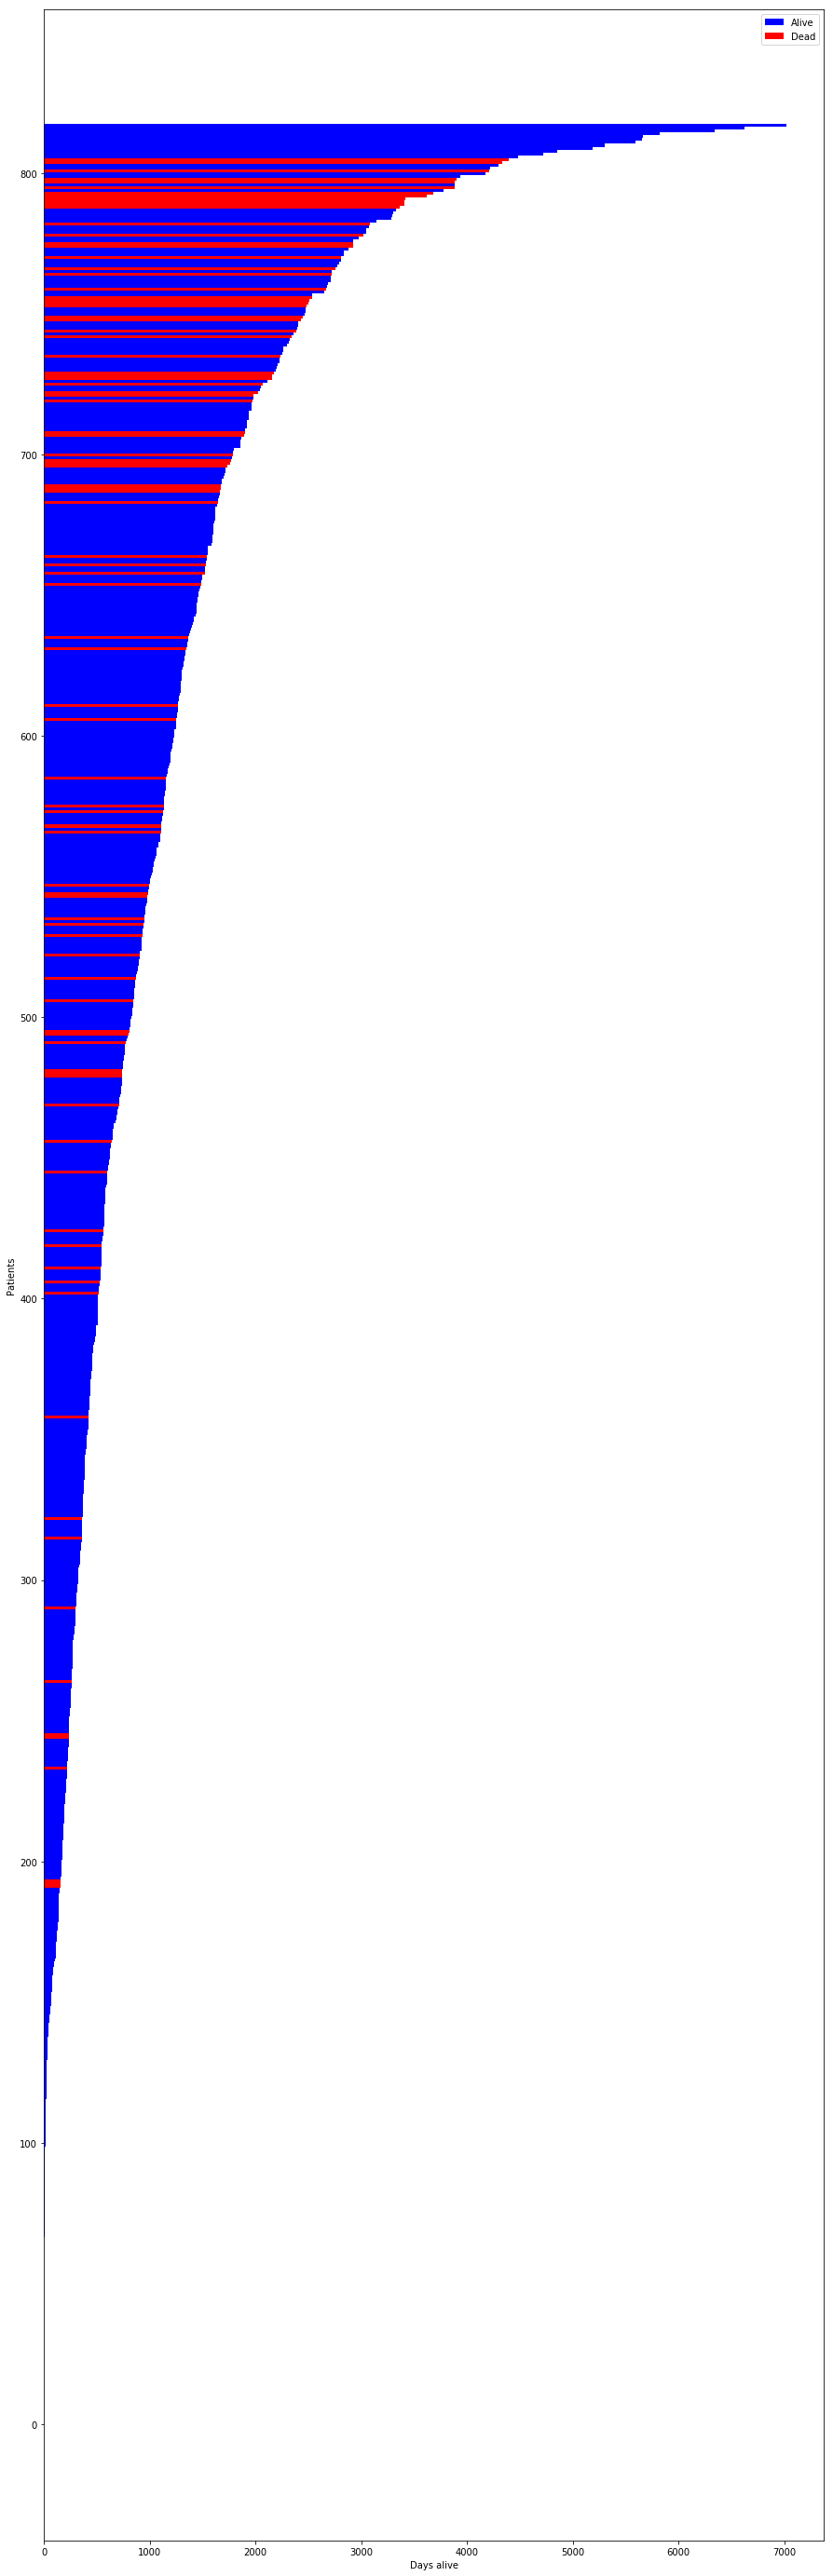

In [5]:
matplotlib.rcParams['figure.figsize'] = [15, 50]

data_sorted = clinical[['Time','Event']].sort_values(by = 'Time').dropna().reset_index(drop=True)
status_slice = data_sorted['Event'] == 1

plt.barh(data_sorted.loc[~status_slice].index, data_sorted.loc[~status_slice,'Time'], height = 1, color = 'b')
plt.barh(data_sorted.loc[status_slice].index, data_sorted.loc[status_slice,'Time'], height = 1, color = 'r')
plt.legend(['Alive', 'Dead'])
plt.ylabel('Patients')
plt.xlabel('Days alive')

---
### Exercises
1.1 Describe the plot and what inferences you are able to make from it

---
# Part 3 - Survival analysis using the clinical data



Ok, now that we've seen the data, lets play around with it.

How does the survival curve looks like in general? We can use the survival package __lifelines__ to figure this out, and generate a *Kaplan Meier plot*

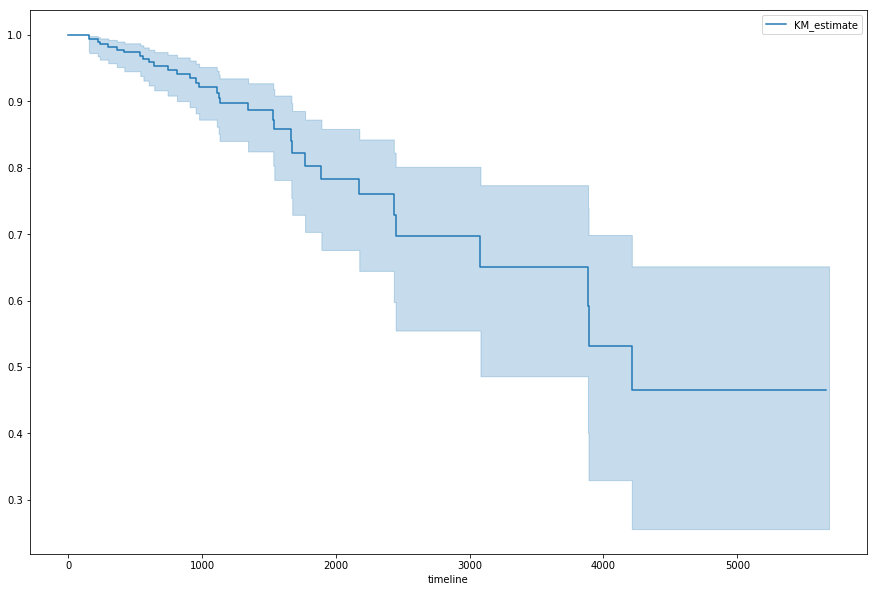

In [6]:
kmf = lifelines.KaplanMeierFitter()

clinical = clinical.dropna()

kmf.fit(clinical['Time'], clinical['Event'])

matplotlib.rcParams['figure.figsize'] = [15, 10]
kmf.plot()

---
### Exercises

2.1 Compare the Kaplan Meier plot with the first one, what additional insights are avaliable on this latter plot?

---

Now we can start to play around with clinical variables that might influence in the survival curve.

You should play around with the groupings and see if you can find some usefull insight

Text(0.5,1,'Metastasis')

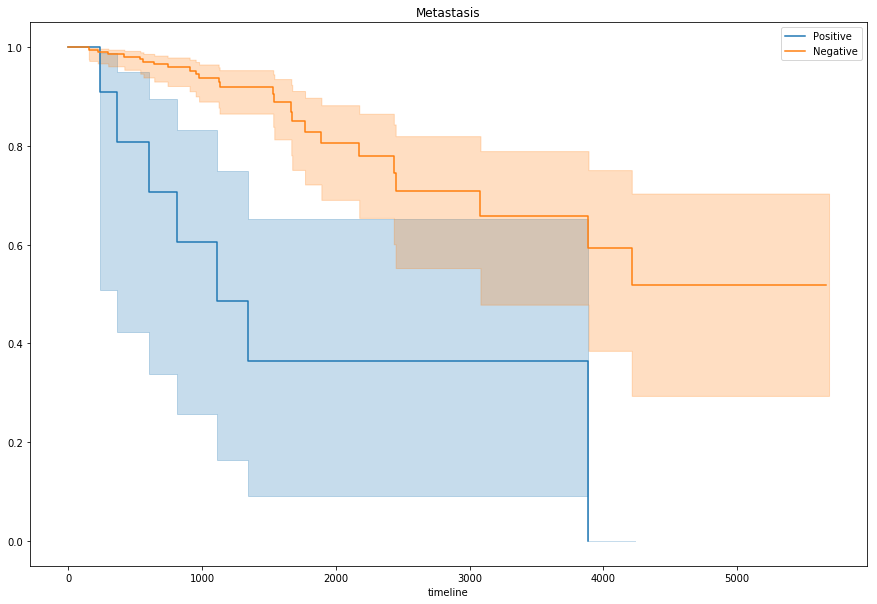

In [17]:
# Define groups here
group_1 = clinical.loc[clinical['Metastasis-Coded'] == 'Positive']
group_2 = clinical.loc[clinical['Metastasis-Coded'] == 'Negative']

kmf.fit(group_1['Time'], group_1['Event'], label='Positive')
ax = kmf.plot()

kmf.fit(group_2['Time'], group_2['Event'], label='Negative')
kmf.plot(ax=ax)

plt.title('Metastasis')

---
### Exercises
3.1 Make at least 3 plots using different separation criteria, and lable them accordingly, save them on the report.

3.2 Make a plot that includes the survival curve for 3 different age groups.

3.3 (Advanced) The **logrank_test** function of the **lifelines** package performs a statistical test on the two groups to see if their "death generation process" is the same. Use this function to obtain a significance statistic for the separations above.

---

# Part 4 - Cox Proportional Hazards model

The next step is to use the Cox Proportional Hazards (CPH) in the data. 

First, let's check the main assumption of the model, the proportionality of hazards, by ploting the hazard functions on a log-log scale and seeing wether they "look" parallel or not.

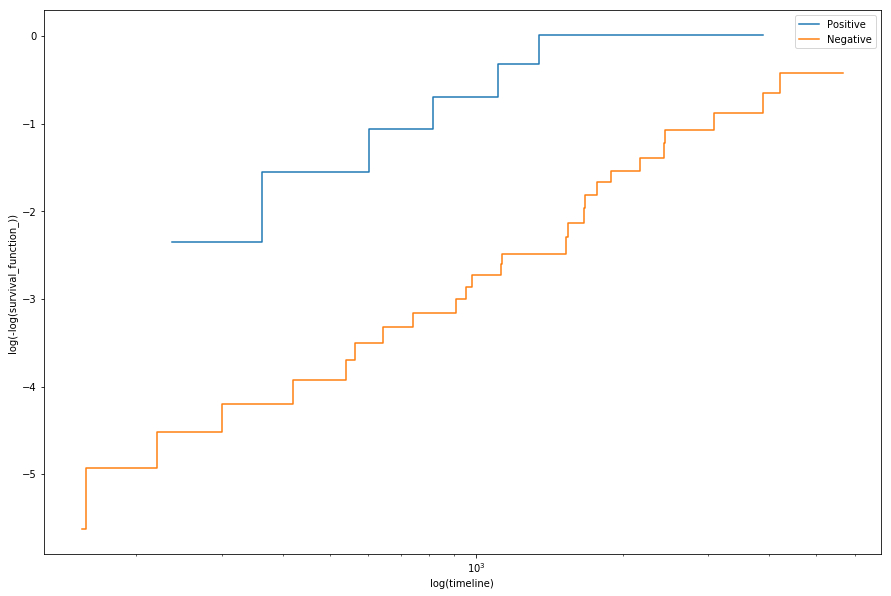

In [8]:
# Define groups here
group_1 = clinical.loc[clinical['Metastasis-Coded'] == 'Positive']
group_2 = clinical.loc[clinical['Metastasis-Coded'] == 'Negative']

kmf.fit(group_1['Time'], group_1['Event'], label='Positive')
ax = kmf.plot_loglogs()

kmf.fit(group_2['Time'], group_2['Event'], label='Negative')
kmf.plot_loglogs(ax=ax)

---
### Exercises

4.1 In your oppinion, does the proportional hazards assumption hold for the Metastasis case? What about other variables you used on the previous exercise? Save the plots on your report to support your claims.

---




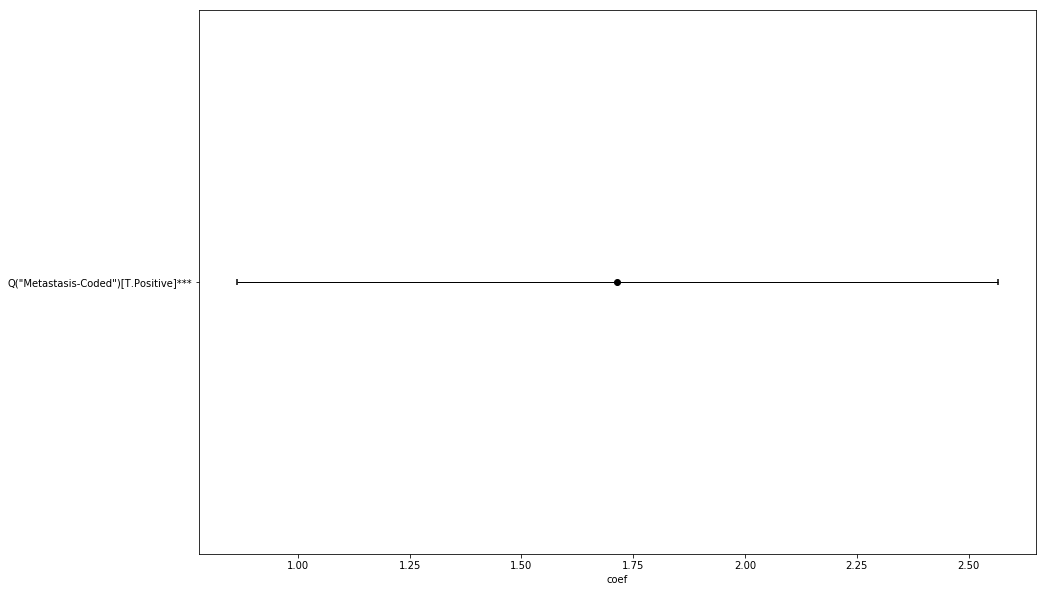

In [59]:
cph = lifelines.CoxPHFitter()

model = 'Time + Event + Q("Metastasis-Coded")'

cox_input = dmatrix(model, data = clinical, return_type = 'dataframe')
cox_input = cox_input.drop(['Intercept'], axis = 1)

cph.fit(cox_input, duration_col='Time', event_col='Event')

cph.plot()


# Part 5 - Incorporating gene expression data

It's time to look at the gene expression data!

First we load the expression data for the same samples. This may take some time, be patient.

We then take a look on how the data looks like. Note that the gene expression has been median normalized, so we get negative gene expression here.

In [ ]:
expression_raw  = pd.read_csv('data/data_expression_median.txt', sep='\t')
expression = expression_raw.set_index('Hugo_Symbol').iloc[:,1:].T
expression

Now we merge the clinical and expression data in one big datastructure, and display the result.

In [ ]:
data = clinical.merge(expression, how='inner', left_on='Sample ID', right_index=True)
data

Now we can incorporate the gene expression data into our Cox regression

In [ ]:
formula = "Q('Diagnosis Age') -1"

X = dmatrix(formula, data)
X